## QBUS6840 - Assignment

<a id='ToC'></a>
<u>**Table of Contents**</u>

1. [Load and Prepare Data](#1.0)
    - Load csv from `data` folder
    - Pre-process dataset to create Time Series
2. [Exploratory Analysis & Summary](#2.0)
    - Plots and Statistical Summary
    - Observing Trends and Averages
    - [Decomposition](#2.3)
    - Other Transformations
3. [Model Development](#3.0)
    - [Exponential Smoothing](#3.1)
    - [Seasonal ARIMA](#3.2)
    - [Neural Network (incl. Autoregression and Recurrent)](#3.3)
    - To discuss: Convolutional NN?
4. [Model Training & Scoring](#4.0)
5. [Evaluation](#5.0)
6. Evaluate on Test Data

<a id='1.0'></a>
## 1. Load and Prepare Data
- 1.1 Data Loading

[Return to top](#ToC)

### 1.1 Data Loading

In [1]:
# Standard Packages
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time Series Analysis (incl. decomposition, exponential smoothing and ARIMA)
import statsmodels as sm
#import statsmodels.api as smt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import pmdarima as pm # For Auto-ARIMA (grid search using AIC/BIC)

# For Deep Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Dense, Flatten, TimeDistributed, SimpleRNN
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
# Load functions and classes from our utilities
from QBUS_utilities import ts_cross_val_split, SimpleModel, RMSE, MAPE
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Set random seed for project
tf.random.set_seed(51)
np.random.seed(51)

In [4]:
# load data - there are no missing values (475 out of 475 count)
df_raw = pd.read_csv('data/UnderemploymentRate_InSample.csv')

display(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  475 non-null    object 
 1   Underemployment Rate  475 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


None

,Date,Underemployment Rate
0,1/06/1978,4.270054
1,1/07/1978,3.933794
2,1/08/1978,4.045333
3,1/09/1978,3.999336
4,1/10/1978,3.722322


<a id='2.0'></a>
## 2. Exploratory Data Analysis
- 2.1 Plot and Statistical Summary
- 2.2 Observing Trends and Averages
- 2.3 Decomposition
- 2.4 Transformations (EDA only)

[Return to top](#ToC)

### 2.1 Plot and Statistical Summary

Convert data to `datetime` and set is as the index. Then plot the time series.

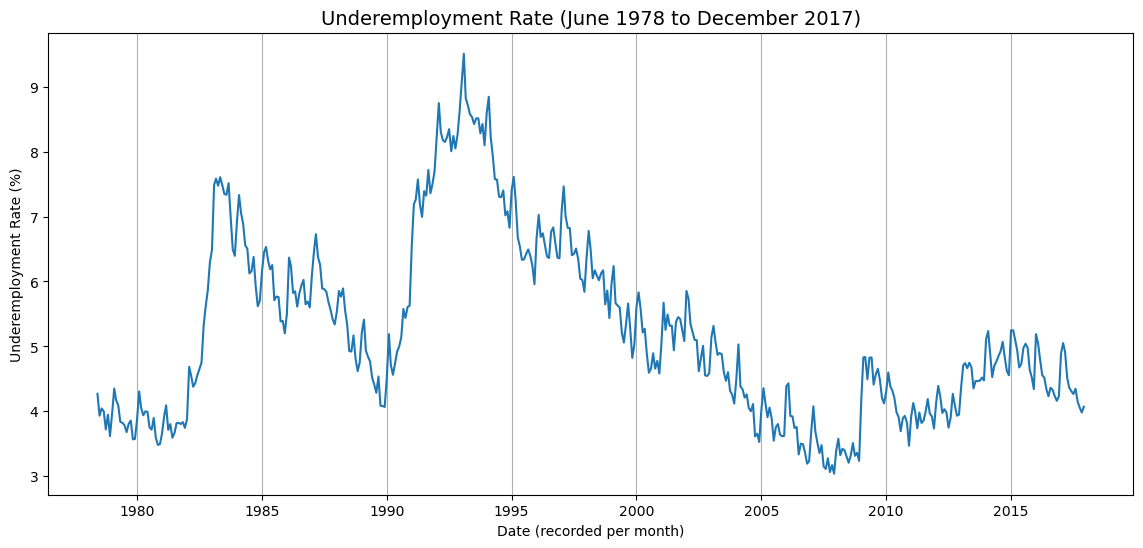

In [5]:
# Convert Date to datetime and set as index
df_ts = df_raw.copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%d/%m/%Y") # Fix format to day-month-year
df_ts = df_ts.set_index('Date')
df_ts.index.freq = 'MS'

# Plot the training dataset
plt.figure(figsize=(14,6))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (recorded per month)', fontsize=10)
plt.ylabel('Underemployment Rate (%)', fontsize=10)

plt.gca().xaxis.grid(True)
plt.plot(df_ts.index, df_ts['Underemployment Rate'])

plt.show()

Plot the box and whisker plot. 

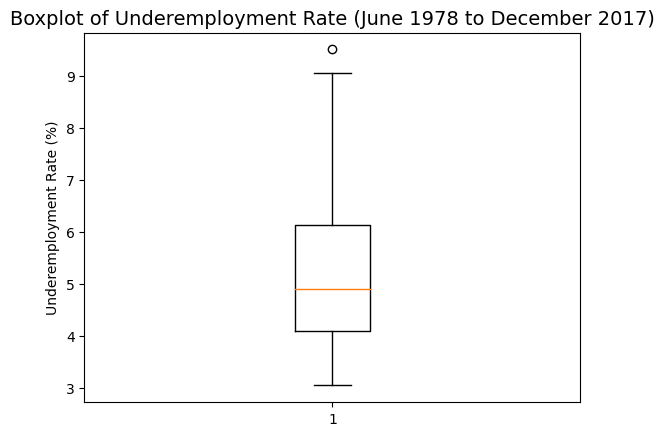

,Underemployment Rate
count,475.000000
mean,5.217498
std,1.386199
min,3.039488
25%,4.093242
50%,4.887481
75%,6.137266
max,9.506796


In [6]:
plt.title('Boxplot of Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.boxplot(df_ts)
plt.ylabel('Underemployment Rate (%)', fontsize=10)
plt.show()

df_ts.describe()

Identify where the maximum and minimum value occurs. Later, in EDA, we explore average rates over 5 and 10 year periods.

In [7]:
print('--------')
print(f"The maximum underemployment rate, {max(df_ts['Underemployment Rate']):.4f}%, \
is found on {df_ts.index[np.argmax(df_ts['Underemployment Rate'])]}")
print('--------')
print(f"The minimum underemployment rate, {min(df_ts['Underemployment Rate']):.4f}%, \
is found on {df_ts.index[np.argmin(df_ts['Underemployment Rate'])]}")
print('--------')

--------
The maximum underemployment rate, 9.5068%, is found on 1993-02-01 00:00:00
--------
The minimum underemployment rate, 3.0395%, is found on 2007-12-01 00:00:00
--------


### 2.2 Observing Trends and Averages

Plot the data with annual smoothing to see the trend.

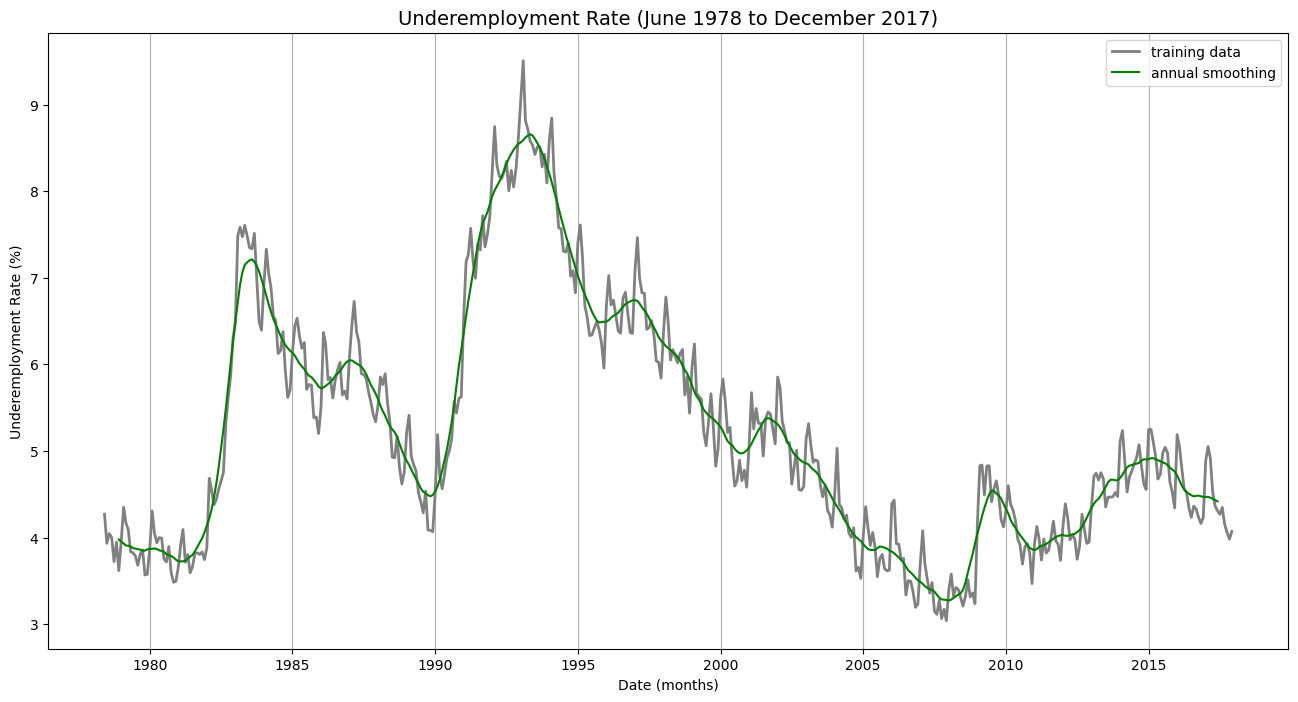

In [8]:
# Smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(16,8))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (months)', fontsize=10)
plt.ylabel('Underemployment Rate (%)', fontsize=10)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='training data', color='grey', linewidth=2)
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='annual smoothing', color='green')

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

Observe the average over a 5 year and 10 year period.

In [9]:
# Average rate (%) per 5 years
print('-----------------')
print('Average rate (%) per 5 year interval:')
df_five = df_ts['Underemployment Rate'].groupby(lambda x: int(x.year/5)).mean().reset_index(drop=True)
for i, year in enumerate(['1975+', '1980+', '1985+', '1990+', '1995+', '2000+', '2005+', '2010+', '2015+']):
    print(f'{year}: {df_five[i]:.4f}%')

# Average per decade
print('-----------------')
print('Average rate (%) per decade:')
df_decade = df_ts['Underemployment Rate'].groupby(lambda x: int(x.year/10)).mean().reset_index(drop=True)
for i, year in enumerate(['1970s', '1980s', '1990s', '2000s', '2010s']):
    print(f'{year}: {df_decade[i]:.4f}%')

-----------------
Average rate (%) per 5 year interval:
1975+: 3.8975%
1980+: 5.2324%
1985+: 5.5175%
1990+: 7.3866%
1995+: 6.2747%
2000+: 4.8486%
2005+: 3.7684%
2010+: 4.2862%
2015+: 4.5944%
-----------------
Average rate (%) per decade:
1970s: 3.8975%
1980s: 5.3750%
1990s: 6.8306%
2000s: 4.3085%
2010s: 4.4017%


<u> **Trial**: Explore multi-year seasonality. </u>

Apply 5 year smoothing to observe the pattern over time, as well as identify if there is a fixed period.

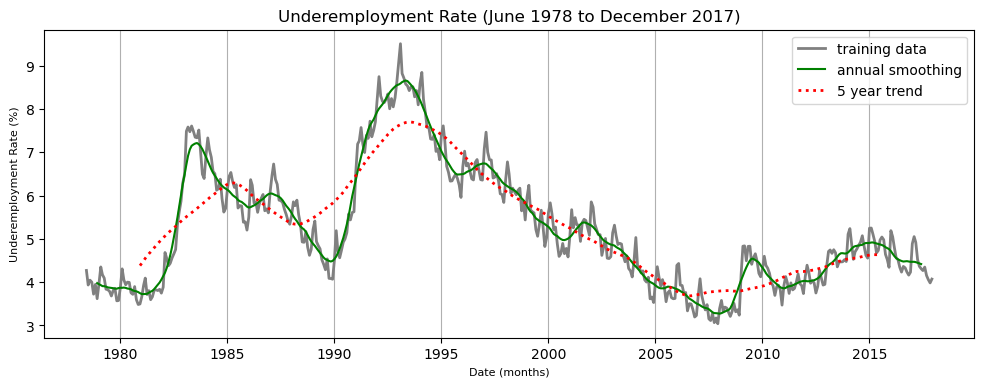

In [10]:
# The trend over time is still quite volatile, we explore multi-year seasonality
## Based on the average rate over 5 year intervals, this might show the general trend

# Let's smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)
df_5year_smoothing = df_ts.rolling(60, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(12, 4))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=12)
plt.xlabel('Date (months)', fontsize=8)
plt.ylabel('Underemployment Rate (%)', fontsize=8)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='training data', color='grey', linewidth=2)
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='annual smoothing', color='green')
plt.plot(df_5year_smoothing.index, df_5year_smoothing['Underemployment Rate'],
         label='5 year trend', color='red', linestyle='dotted', linewidth=2)

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

While this does show smoothing and general direction, this is insufficient to conclude a seasonal pattern. We can observe the peaks/troughs of the plot don't occur in consistent intervals. Rather, this suggests possible cyclical patterns over time.

<a id='2.3'></a>
### 2.3 Decomposition for EDA

In [11]:
## TODO: Add Julie's Decomposition from Scratch

By utilising the statsmodels package, we can quickly find the trend and seasonality and review the residuals to determine if the trend is captured effectively.


####---- Decomposition Plot: additive model ----####
Seasonality, m = 12


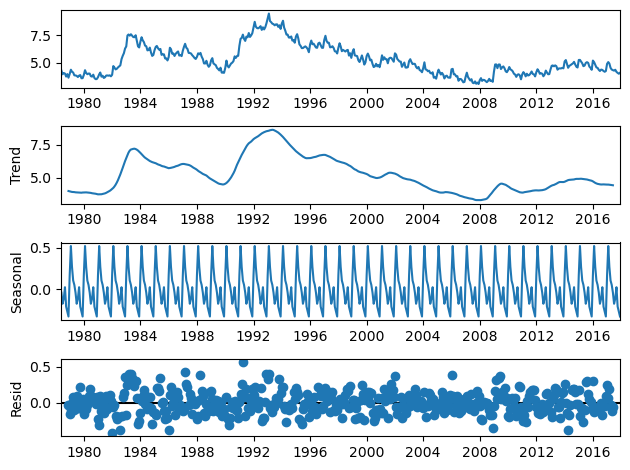


####---- Decomposition Plot: multiplicative model ----####
Seasonality, m = 12


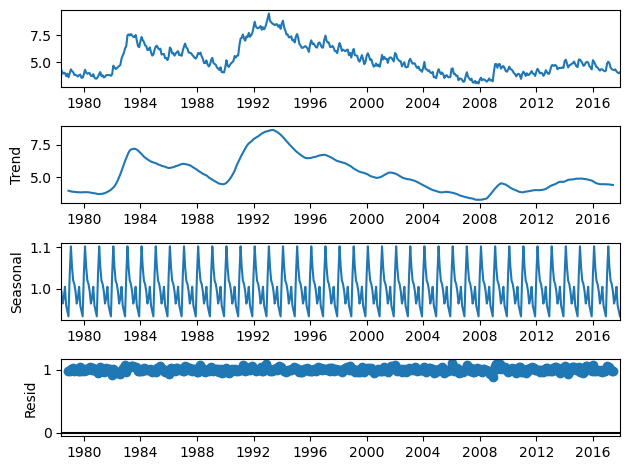

In [12]:
for model_type in ['additive', 'multiplicative']:
    decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                       model = model_type,
                                                       period = None,
                                                      )
    print(f'\n####---- Decomposition Plot: {model_type} model ----####')
    print(f'Seasonality, m = {decomposition.seasonal.nunique()}')
    decomposition.plot()

    plt.show()

We see the through decomposition there is seasonal period m = 12. Further, forcing other seasonal periods worsens the residual plot.


####---- Decomposition Plot: additive model ----####
Seasonality, m = 30


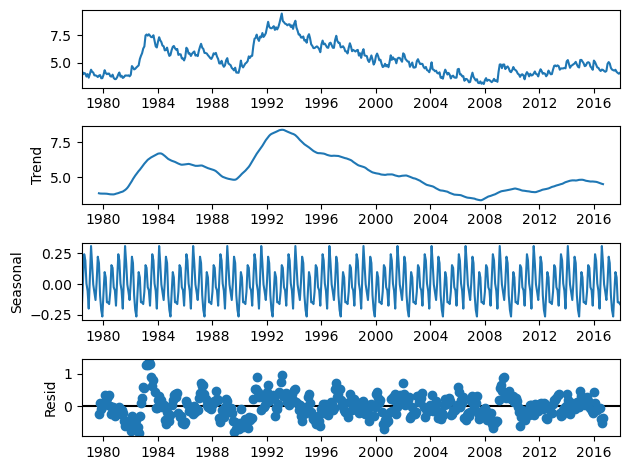


####---- Decomposition Plot: multiplicative model ----####
Seasonality, m = 60


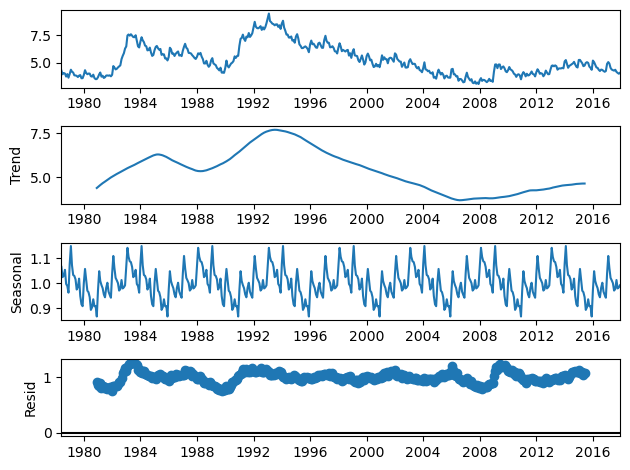

In [13]:
for model_type, model_seasons in zip(['additive', 'multiplicative'], [30, 60]):
    decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                       model = model_type,
                                                       period = model_seasons,
                                                      )
    print(f'\n####---- Decomposition Plot: {model_type} model ----####')
    print(f'Seasonality, m = {decomposition.seasonal.nunique()}')
    decomposition.plot()

    plt.show()

### 1.4 Transformations

***Note:** These transformations are exploratory only. After earlier trials, these are not used further in this notebook.*

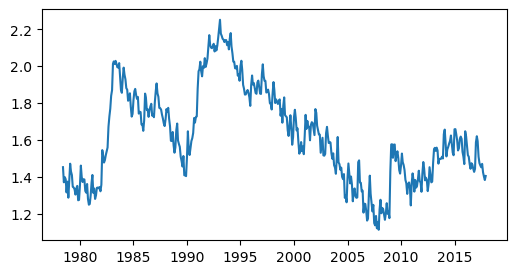

In [14]:
# Transformation:
## (a) log scale
## (b) Differencing
plt.figure(figsize=(6,3))
df_log = np.log(df_ts)
plt.plot(df_log)
plt.show()

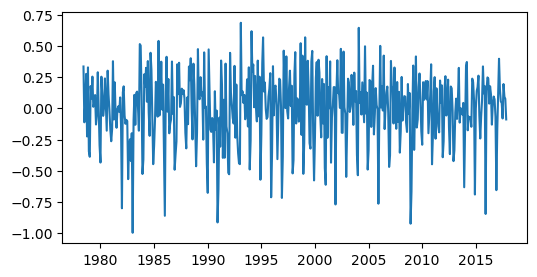

In [15]:
plt.figure(figsize=(6,3))
df_diff = df_ts - df_ts.shift(-1)
plt.plot(df_diff)
plt.show()

In [16]:
# EXTRA

<a id='3.0'></a>
## 3. Model Development
- 3.1 Exponential Smoothing
- 3.2 ARIMA
- 3.2 Neural Networks

[Return to top](#ToC)

For modelling, we need to quickly identify candidate models to evaluate using an expanding window cross-validation set. Typically, hyper-parameters are tuned using this cross-validation and then trained on the whole dataset before evaluating on the test data.

However, given the scope of models explored and number of hyper-parameters, we are only using one training/validation split to optimize and fit each type of model. Cross-Validation for high-performing models and hyper-parameter settings are then all evaluated in **[Section 4](#4.0)** to select the best model to use with the test set

In [17]:
ts_train = df_ts[:-24]
ts_val = df_ts[-24:]
print(f'Training data is split into Train - {ts_train.shape} and Validation - {ts_val.shape}')

Training data is split into Train - (451, 1) and Validation - (24, 1)


<a id="3.1"></a>
### 3.1 Exponential Smoothing
- Simple Exponential Smoothing
- Holt Smoothing
- Holt-Winters Smoothing

[Return to top](#ToC)

#### 3.1.1 Simple Exponential Smoothing

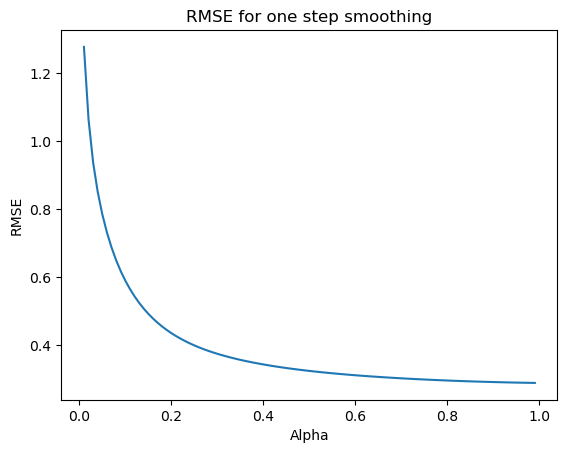

Optimal Alpha for 1-step forecast = 0.9900


In [18]:
# Create values for alpha
alphas = np.arange(0.01,1,0.01)

# Initialize an empty list to store RMSE for each value of alpha
rmse_alphas = []

# Loop through alphas
for a in alphas:
    smoothed = ts_train.ewm(alpha = a, adjust=False).mean()
    rmse_alphas.append(RMSE(ts_train[1:], smoothed[:-1]))
    
# Plot the error for each alpha
plt.figure()
plt.plot(alphas, rmse_alphas)
plt.title("RMSE for one step smoothing")
plt.ylabel("RMSE")
plt.xlabel("Alpha")

plt.show()

# Find the best alpha
optimal_alpha = alphas[np.argmin(rmse_alphas)]
print(f'Optimal Alpha for 1-step forecast = {optimal_alpha:.4f}')

In [19]:
SES = SimpleExpSmoothing(ts_train).fit()
print('Simple Exponential Smoothing model fit...')

y_fitted = SES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = SES.forecast(len(ts_val))
print('-----------------------')
print('      Scoring SES      ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

Simple Exponential Smoothing model fit...
-----------------------
      Scoring SES      
-----------------------
RMSE on training set  : 0.2872
RMSE on validation set: 0.3572
-----------------------


#### 3.1.2 Trend Corrected Exponential Smoothing

In [20]:
### TODO: This is very slow! Must be a faster way to vectorize / use previous values

In [21]:
# Create values for alpha and beta
alphas = np.arange(0.01,1,0.05)
betas = np.arange(0.01,1,0.05)
# Initialize l0 and b0
l_0 = df_ts.iloc[0]
b_0 = df_ts.iloc[1] - l_0

# Initialize an empty list to store RMSE for each value of alpha and betas
rmse_alphas_betas = np.zeros((len(alphas),len(betas)))

# Evaluate combinations of alpha and beta
for k, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        # Initialize values
        holts_linear = []
        l = [l_0]
        b = [b_0]
        
        for i in range(len(df_ts)):
            l.append(alpha * df_ts.iloc[i] + (1 - alpha)*(l[i] + b[i])) # Calculate level l_t
            b.append(beta * (l[i+1] - l[i]) + (1 - beta*b[i]))          # Calcualate trend b_t
            holts_linear.append(l[i+1] + b[i+1])                        # Add l_t and b_t
        
        rmse_alphas_betas[k, j] = RMSE(holts_linear[:-1], df_ts.iloc[1:])

rmse_alphas_betas[:0]

array([], shape=(0, 20), dtype=float64)

In [22]:
x, y = np.unravel_index(np.argmin(rmse_alphas_betas), rmse_alphas_betas.shape)

optimal_alpha = alphas[x]
optimal_beta = betas[y]

print(f'Optimal alpha: {optimal_alpha:.4f}')
print(f'Optimal beta: {optimal_beta:.4f}')

## TODO: CHECK VALUES

Optimal alpha: 0.9100
Optimal beta: 0.9100


In [23]:
Holt_ES = Holt(ts_train).fit(smoothing_level=optimal_alpha,
                             smoothing_trend=optimal_beta
                            )

y_fitted = Holt_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = Holt_ES.forecast(len(ts_val))

print('-----------------------')
print('     Scoring TCES      ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

-----------------------
     Scoring TCES      
-----------------------
RMSE on training set  : 0.3714
RMSE on validation set: 2.4179
-----------------------


#### 3.1.3 Holt-Winters Exponential Smoothing

In [24]:
HoltWinters_add_ES = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='add').fit()
HoltWinters_mul_ES = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='mul').fit()

y_fitted = HoltWinters_add_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = HoltWinters_add_ES.forecast(len(ts_val))

print('-----------------------')
print(' Scoring Additive HWES ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

y_fitted = HoltWinters_mul_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = HoltWinters_mul_ES.forecast(len(ts_val))

print('-----------------------')
print('Scoring Multiplicative HWES')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

-----------------------
 Scoring Additive HWES 
-----------------------
RMSE on training set  : 0.1843
RMSE on validation set: 0.1843
-----------------------
-----------------------
Scoring Multiplicative HWES
-----------------------
RMSE on training set  : 0.1883
RMSE on validation set: 0.2845
-----------------------


In [25]:
params = ['smoothing_level',
          'smoothing_trend',
          'smoothing_seasonal',
          'initial_level',
          'initial_trend',
         ]

print('Holt-Winters hyper-parameters:')

hw_params = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\gamma$", r"$l_0$", "$b_0$",
                                r"$S_{0}$", r"$S_{1}$", r"$S_{2}$", r"$S_{3}$", r"$S_{4}$", r"$S_{5}$", r"$S_{6}$",
                                r"$S_{7}$", r"$S_{8}$", r"$S_{9}$", r"$S_{10}$", r"$S_{11}$", "SSE"],
                         columns=['Additive', 'Multiplicative']
                        )
hw_params['Additive'] = [HoltWinters_add_ES.params[p] for p in params] \
                    + [HoltWinters_add_ES.params['initial_seasons'][i] for i in range(12)] \
                    + [HoltWinters_add_ES.sse]

hw_params['Multiplicative'] = [HoltWinters_mul_ES.params[p] for p in params] \
                            + [HoltWinters_mul_ES.params['initial_seasons'][i] for i in range(12)] \
                            + [HoltWinters_mul_ES.sse]


hw_params.drop(index=[r"$S_{10}$", r"$S_{11}$"]).style.format(precision=4) #For some reason 10 and 11 display funny - can remove drop to view columns

Holt-Winters hyper-parameters:


,Additive,Multiplicative
$\alpha$,0.8064,0.7997
$\beta$,0.1331,0.1323
$\gamma$,0.0000,0.0000
$l_0$,4.2867,3.7700
$b_0$,-0.0395,-0.0307
$S_{0}$,-0.0095,1.1305
$S_{1}$,-0.1500,1.1047
$S_{2}$,-0.0858,1.1170
$S_{3}$,0.0515,1.1450
$S_{4}$,-0.1868,1.0947


**Holt-Winters Exponential Smoothing** outperforms other Exponential Smoothing models in both the training and validation set. This makes sense as we have determined there is annual seasonality in the data.

We will evaluate the performance difference between Additive and Multiplicative seasonality in the Model Evaluation section.

<a id="3.2"></a>
### 3.2 Seasonal ARIMA
- Stationarity
- Auto-Correlation and Partial Auto-Correlation Plots
- Seasonal ARIMA

[Return to top](#ToC)

#### 3.2.1 Stationarity

In [26]:
## TO DO: Invertability Check!

The time series is not stationary (i.e. the mean, variance and co-variance are a function of time).

To explore what differencing may be appropriate (incl. seasonal differencing), we apply the Augmented Dickey-Fuller test.

The Augmented Dickey-Fuller test for the original time series is:
	ADF = -2.0209
	P-Value = 0.2775

Plotting the ADF results for differencing, increased order by row and increased seasonal order by column



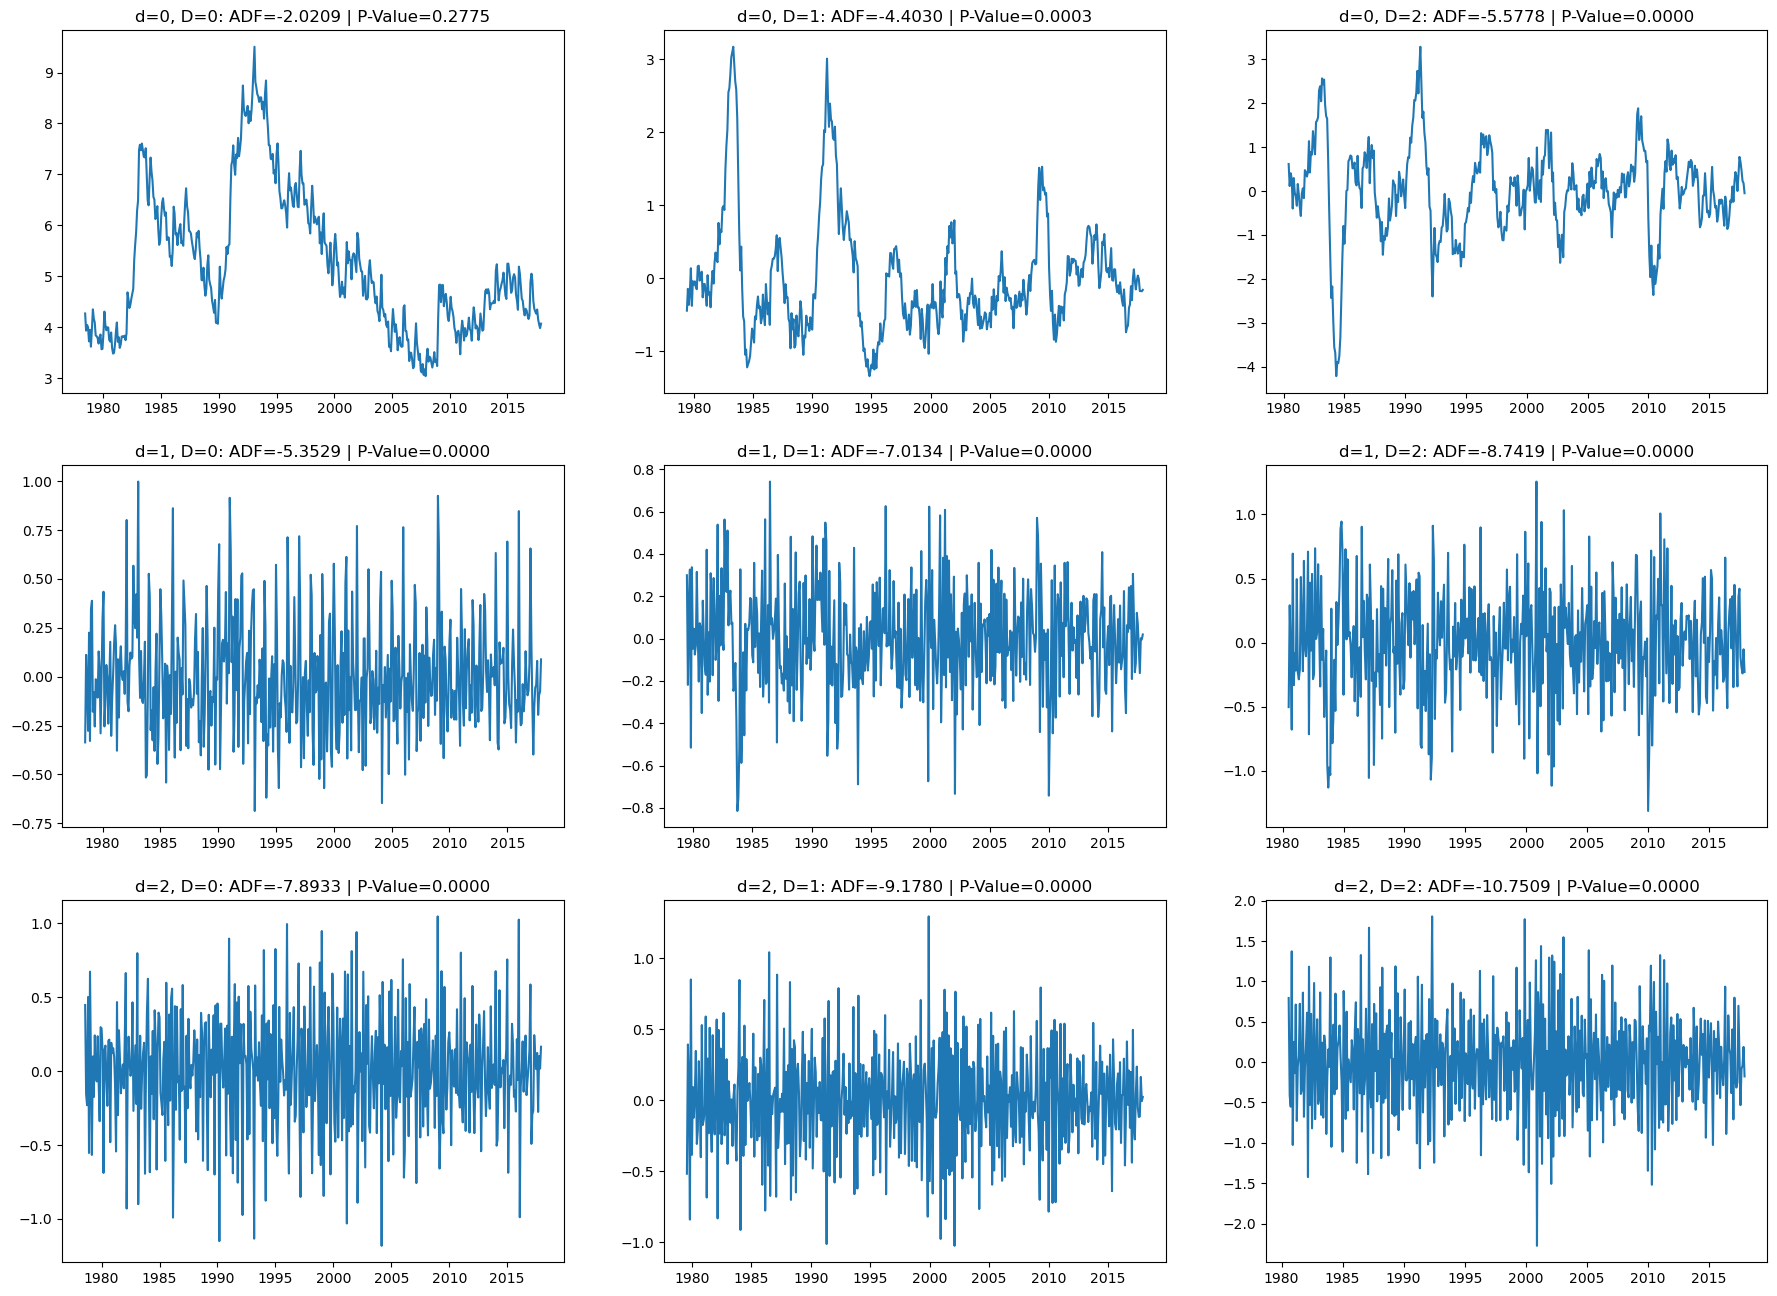

In [27]:
# We can apply the Augmented Dickey-Fuller test to evaluate stationarity, and then compare these to ACF/PACF plots below
adf_test = sm.tsa.stattools.adfuller(df_ts)
print(f'The Augmented Dickey-Fuller test for the original time series is:\n\tADF = {adf_test[0]:.4f}\n\tP-Value = {adf_test[1]:.4f}')
print()
print('Plotting the ADF results for differencing, increased order by row and increased seasonal order by column')
print()

# Plot the differencing
plt.figure(figsize=(22,16))
nrows, ncols = 3, 3

# Create a loop for differencing order [d, D]
for i, diff_plot in enumerate([[0, 0],
                               [0, 1],
                               [0, 2],
                               [1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    plt.subplot(nrows, ncols, i+1)
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)
        
    adf_test = sm.tsa.stattools.adfuller(df_diff.dropna())
    plt.title(f'd={diff_plot[0]}, D={diff_plot[1]}: ADF={adf_test[0]:.4f} | P-Value={adf_test[1]:.4f}')
    plt.plot(df_diff)
    
plt.show()

It looks like even first order differencing provides a suitable level of stationarity. While d=2, D=2 has the best score, any seasonal differencing or second order differencing has similar scores.

#### 3.2.2 Auto-Correlation and Partial Auto-Correlation Plots

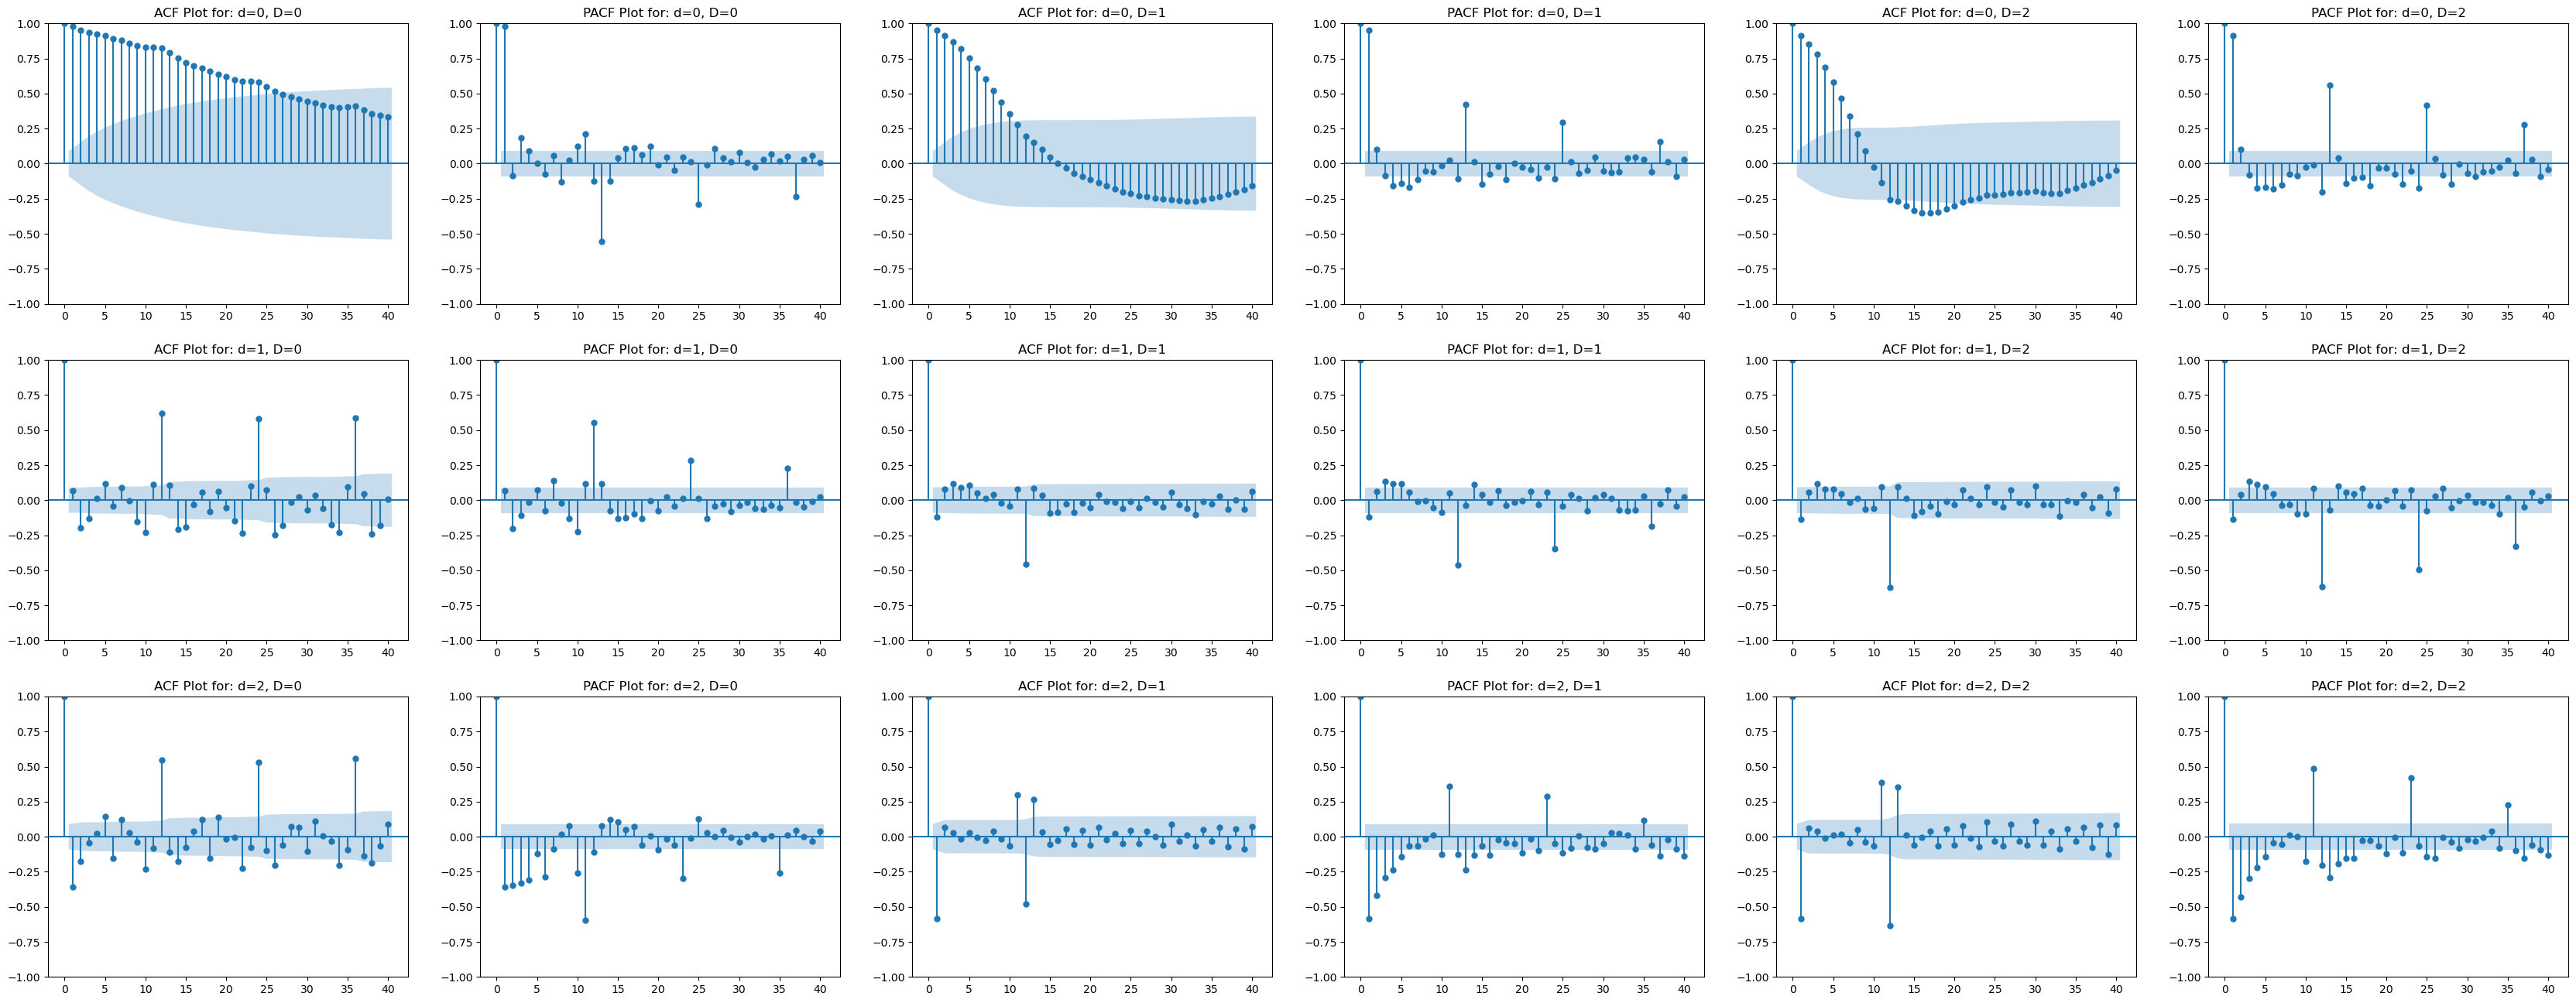

In [28]:
# Next we look at the ACF and PACF plot to determine:
##    (a) whether the data is appropriately stationary, and
##    (b) candidates for Auto-Regression (AR) and Moving Average (MA)
plt.figure(figsize=(42,16))
nrows, ncols = 3, 6

for i, diff_plot in enumerate([[0, 0],
                               [0, 1],
                               [0, 2],
                               [1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)

    sm.graphics.tsaplots.plot_acf(df_diff.dropna(),
                                  ax=plt.subplot(nrows, ncols, 2*i+1), lags=40,
                                  title=f'ACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                 )
    sm.graphics.tsaplots.plot_pacf(df_diff.dropna(), method='ywm', lags=40, # ADDED
                                   ax=plt.subplot(nrows, ncols, 2*i+2),
                                   title=f'PACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                  )
plt.show()

Based on the ACF and PACF plots, at least first order differencing is required (i.e. $d > 0$) and likely seasonal differencing too ($D > 0$).

**Diffrencing**

However, there isn't a large improvement after first order differencing, while not much improvement after $D = 1$. Therefore, exploring:
- ${d}\in\{1, 2\}$
- ${D}\in\{0, 1\}$

**Moving Avereage**

From the stationary ACF plots, there are various potential points where the values stop being significant - sometimes 1, 2, 3, 5, 7. For seasonality, the significant figure drops after the first seasonal period. Therefore, exploring:
- ${q}\in\{1, 2, 3, 5, 7\}$ **TODO: May try 4**
- ${Q}\in\{0, 1\}$ - **TODO: May try 2 with best values**

**Auto-Regression**

From the stationary PACF plots, the values fall slowly often to 5 or 7. For seasonality, there is a gradual fall each seasonal period. Therefore, exploring:
- ${p}\in\{1, 3, 5, 7\}$
- ${P}\in\{0, 1, 2, 3\}$

In [29]:
SARIMA_params = {
    'p': [1,3,5,7],
    'd': [1,2],
    'q': [1,2,3,5,7],
    'P': [0,1,2,3],
    'D': [0,1],
    'Q': [0,1]
}

print('Total no. of cominations for testing:', np.product([len(SARIMA_params[p]) for p in SARIMA_params]))

Total no. of cominations for testing: 640


Given the no. of combinations, grid search across all possibilities is too much. We will refine this to a smaller set for evaluation. Additionally, we can use the statsmodels package to find an appropriate ARMA order using AIC or BIC.

In [30]:
# Have computed values already, load from save or redo below
use_saved_file = True
if use_saved_file:
    ARMA_AIC_BIC = pd.read_csv('log_results/AIC_BIC_ARMA(p,q).csv', index_col=0)
else:
    ## ARMA selection using AIC/BIC
    AIC = []
    BIC = []
    for i, diff_plot in enumerate([[1, 0],
                                   [1, 1],
                                   [2, 0],
                                   [2, 1],
                                  ]):
        print(f'Finding ARMA(p,q) for d={diff_plot[0]}, D={diff_plot[1]}')
        df_diff = df_ts.copy()

        for base_diff in range(diff_plot[0]):
            df_diff -= df_diff.shift(1)

        for seas_diff in range(diff_plot[1]):
            df_diff -= df_diff.shift(12)

        order = sm.tsa.stattools.arma_order_select_ic(df_diff,max_ar=5,max_ma=5,ic=['aic'])
        AIC.append(order.aic_min_order)
        order = sm.tsa.stattools.arma_order_select_ic(df_diff,max_ar=5,max_ma=5,ic=['bic'])
        BIC.append(order.bic_min_order)

    print('-----------------------------')
    print('           Results           ')
    print('-----------------------------')
    for i, diff_plot in enumerate([[1, 0],
                                   [1, 1],
                                   [2, 0],
                                   [2, 1],
                                  ]):
        print(f'Proposed ARMA for d = {diff_plot[0]} and D = {diff_plot[1]}:')
        print(f'\tAIC: {AIC[i]}')
        print(f'\tBIC: {BIC[i]}')
        results = [(x, y) for x,y in zip(AIC, BIC)]
        ARMA_AIC_BIC = pd.DataFrame(data=results, columns=['AIC', 'BIC'], index=['d=1|D=0', 'd=1|D=1', 'd=2|D=0', 'd=2|D=1'])
        ARMA_AIC_BIC.to_csv('log_results/AIC_BIC_ARMA(p,q).csv')
        
display(ARMA_AIC_BIC)

,AIC,BIC
d=1|D=0,"(2, 2)","(2, 2)"
d=1|D=1,"(5, 5)","(5, 5)"
d=2|D=0,"(5, 5)","(3, 4)"
d=2|D=1,"(1, 4)","(1, 4)"


#### 3.2.3 Seasonal ARIMA

In [31]:
# We use Auto-ARIMA first to find optimal values, then review a limited no. of alternatives
## This is to massively reduce the search space to find candidates for cross-validation scoring/evaluation

auto_ARIMA = pm.auto_arima(df_ts, seasonal=True, m=12, suppress_warnings=True,
                           max_p = max(SARIMA_params['p']), max_q = max(SARIMA_params['q']),
                           max_d = max(SARIMA_params['d']), max_D = max(SARIMA_params['D']),
                           max_P = max(SARIMA_params['P']), max_Q = max(SARIMA_params['Q']),
                          )

print('Hyper-parameters based on Auto ARIMA:')
print(f'ARIMA(p,d,q) = {auto_ARIMA.order}')
print(f'SARIMA(P,D,Q) = {auto_ARIMA.seasonal_order}') 

Hyper-parameters based on Auto ARIMA:
ARIMA(p,d,q) = (2, 1, 2)
SARIMA(P,D,Q) = (1, 0, 1, 12)


In [32]:
# For now, we evaluate potential combinations for evaluation below
SARIMA_212101 = sm.tsa.statespace.sarimax.SARIMAX(df_ts, 
                                                  order = (2,1,2),              # Non-seasonal component
                                                  seasonal_order = (1,0,1,12),  # Seasonal component
                                                  freq='MS'
                                                 ).fit()



SARIMA_222111 = sm.tsa.statespace.sarimax.SARIMAX(df_ts, 
                                                  order = (2,2,2),              # Non-seasonal component
                                                  seasonal_order = (1,1,1,12),  # Seasonal component
                                                  freq='MS'
                                                 ).fit()

SARIMA_713210 = sm.tsa.statespace.sarimax.SARIMAX(df_ts, 
                                                  order = (7,1,3),              # Non-seasonal component
                                                  seasonal_order = (2,1,0,12),  # Seasonal component
                                                  freq='MS'
                                                 ).fit()

SARIMA_515311 = sm.tsa.statespace.sarimax.SARIMAX(df_ts, 
                                                  order = (5,1,5),              # Non-seasonal component
                                                  seasonal_order = (3,1,3,12),  # Seasonal component
                                                  freq='MS'
                                                 ).fit()

C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\

In [33]:
len(ts_train[1:]), len(auto_ARIMA.predict_in_sample(start=1, end=len(ts_train)-1))

(450, 450)

In [34]:
y_fitted = auto_ARIMA.predict_in_sample(start=13, end=len(ts_train)-1)
y_preds = auto_ARIMA.predict(len(ts_val))

print('-----------------------')
print('   Scoring Auto-ARIMA  ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train[13:], y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

print('-----------------------')
print('    Scoring S-ARIMA    ')
print('-----------------------')

for model in [SARIMA_212101, SARIMA_222111, SARIMA_713210, SARIMA_515311]:
    print(f'Model Parameters: S-ARIMA {model.specification["order"]}{model.specification["seasonal_order"]}')
    y_fitted = model.predict(start=ts_train.index[0], end=ts_train.index[-1])
    y_preds = model.forecast(len(ts_val))
    print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
    print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
    print('-----------------------')
    

-----------------------
   Scoring Auto-ARIMA  
-----------------------
RMSE on training set  : 0.1881
RMSE on validation set: 0.2037
-----------------------
-----------------------
    Scoring S-ARIMA    
-----------------------
Model Parameters: S-ARIMA (2, 1, 2)(1, 0, 1, 12)
RMSE on training set  : 0.2767
RMSE on validation set: 0.2037
-----------------------
Model Parameters: S-ARIMA (2, 2, 2)(1, 1, 1, 12)
RMSE on training set  : 0.3327
RMSE on validation set: 0.1948
-----------------------
Model Parameters: S-ARIMA (7, 1, 3)(2, 1, 0, 12)
RMSE on training set  : 0.3007
RMSE on validation set: 0.1799
-----------------------
Model Parameters: S-ARIMA (5, 1, 5)(3, 1, 3, 12)
RMSE on training set  : 0.2946
RMSE on validation set: 0.1842
-----------------------


<a id="3.3"></a>
### 3.3 Neural Networks
- Autoregression Network
- Recurrent Neural Network
    - Hyper-parameter Optimisation

[Return to top](#ToC)

#### 3.3.1 Autoregression Neural Network

In [35]:
# Set parameters for our network
time_window = 24

scaler = MinMaxScaler(feature_range=(0, 1))


scaler.fit(ts_train)
ts_train_scaled = scaler.transform(ts_train)
ts_val_scaled = scaler.transform(ts_val)

train_size = len(ts_train)-time_window
val_size = len(ts_val)-time_window

In [38]:
X_train, y_train = [], []
X_train_scaled, y_train_scaled = [], []

# Training data
for i in range(time_window, len(ts_train)):
    X_train.append(ts_train.iloc[i-time_window:i].values)
    X_train_scaled.append(ts_train_scaled[i-time_window:i])
    y_train.append(ts_train.iloc[i].values)
    y_train_scaled.append(ts_train_scaled[i])
    
# TODO: Data for 24-step predictions
    
X_train = np.array(X_train).reshape(-1,time_window)
X_train_scaled = np.array(X_train_scaled).reshape(-1,time_window)
y_train = np.array(y_train).reshape(-1,1)
y_train_scaled = np.array(y_train_scaled).reshape(-1,1)

X_train.shape, y_train.shape

((427, 24), (427, 1))

In [39]:
# Build the FFN model with 1 step ahead
FFN_model = Sequential()
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(1))
FFN_model.compile(loss='mean_squared_error', optimizer='adam')
FFN_model.summary()

# TODO: Build the FFN model with 24 steps for each prediction
#FFN_model = Sequential()
#FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
#FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
#FFN_model.add(Dense(24))
#FFN_model.compile(loss='mean_squared_error', optimizer='adam')
#FFN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [40]:
FFN_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=20 , verbose=1) # Increase to 500 later

Epoch 1/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 3/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 5/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 7/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 8/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 9/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 10/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 11/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 12/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 13/100
22/22 [=================

In [41]:
y_fitted = scaler.inverse_transform(FFN_model.predict(X_train_scaled))

# For 24 step ahead, use next prediction as the input for the next time step
X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,time_window)
y_preds_scaled = []
for step in range(time_window):
    next_pred = FFN_model.predict(X_val_scaled, verbose=0)
    y_preds_scaled.append(next_pred)
    
    # Update X_val
    X_val_scaled = np.concatenate([X_val_scaled[:,1:], next_pred], axis=1)
    
y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))

print('-----------------------')
print('  Scoring FFN Network  ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train[time_window:], y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring FFN Network  
-----------------------
RMSE on training set  : 0.1885
RMSE on validation set: 0.2623
-----------------------


#### 3.3.2 Recurrent Neural Network

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_train_scaled = scaler.fit_transform(ts_train)

In [52]:
len(ts_train)

451

In [59]:
time_window = 12
X_train, y_train = [], []
X_train_scaled, y_train_scaled = [], []

# Training data
for i in range(time_window, len(ts_train)):
    X_train.append(ts_train.iloc[i-time_window:i].values)
    X_train_scaled.append(ts_train_scaled[i-time_window:i])
    y_train.append(ts_train.iloc[i].values)
    y_train_scaled.append(ts_train_scaled[i])
    
# TODO: Data for 24-step predictions

# data dimension transform for Sequential RNN
X_train = np.array(X_train).reshape(-1,1,time_window)
X_train_scaled = np.array(X_train_scaled).reshape(-1,1,time_window)
y_train = np.array(y_train).reshape(-1,1)
y_train_scaled = np.array(y_train_scaled).reshape(-1,1)
    
print(y_train_scaled.shape)
print(X_train_scaled.shape)

(439, 1)
(439, 1, 12)


**Hyper-Parameter Tuning:** Activation Function

In [88]:
# Create initial model

# Result list
train_rmse =[]
val_rmse = [] 

#Activation function test
activation_func_list = ['LeakyReLU','relu','sigmoid','tanh'] 
for activation_func in activation_func_list:
    #score list
    trainScore_activation_list = []
    valScore_activation_list = []
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(10, activation=activation_func)) # This is what we are tuning
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='Nadam', loss='mse')
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=10, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tActivation: {activation_func}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([activation_func_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Activation Func', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Activation: LeakyReLU
-----------------------
RMSE on training set  : 0.3694
RMSE on validation set: 0.5238
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Activation: relu
-----------------------
RMSE on training set  : 0.6582
RMSE on validation set: 0.8991
-----------------------
14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN Network  
	Activation: sigmoid
-----------------------
RMSE on training set  : 0.4920
RMSE on validation set: 0.7943
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Activation: tanh
-----------------------
RMSE on training set  : 0.4925
RMSE on validation set: 0.6453
-----------------------
########################
Results:


,Activation Func,Train RMSE,Val RMSE
0,LeakyReLU,0.369434,0.523764
1,relu,0.658249,0.899135
2,sigmoid,0.492027,0.794284
3,tanh,0.492519,0.645263


**Hyper-Parameter Tuning:** Optimizer

In [89]:
optimizer_func_list = ['sgd','adam','Nadam','RMSprop']
# Result list
train_rmse =[]
val_rmse = [] 

for optimizer_func in optimizer_func_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(10, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer=optimizer_func, loss='mse') # This is what we are tuning
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=10, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tOptimizer: {optimizer_func}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([optimizer_func_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Optimization Func', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
\Optimizer: sgd
-----------------------
RMSE on training set  : 0.6625
RMSE on validation set: 0.7937
-----------------------
14/14 [==============================] - 0s 885us/step
-----------------------
  Scoring RNN Network  
\Optimizer: adam
-----------------------
RMSE on training set  : 0.3650
RMSE on validation set: 0.4624
-----------------------
14/14 [==============================] - 0s 930us/step
-----------------------
  Scoring RNN Network  
\Optimizer: Nadam
-----------------------
RMSE on training set  : 0.7414
RMSE on validation set: 0.8406
-----------------------
14/14 [==============================] - 0s 0s/step
-----------------------
  Scoring RNN Network  
\Optimizer: RMSprop
-----------------------
RMSE on training set  : 0.4499
RMSE on validation set: 0.3254
-----------------------
########################
Results:


,Optimization Func,Train RMSE,Val RMSE
0,sgd,0.662514,0.793735
1,adam,0.365003,0.462378
2,Nadam,0.741383,0.840558
3,RMSprop,0.449949,0.325354


**Hyper-Parameter Tuning:** Batch Size

In [98]:
batch_num_list = [1, 12,24,144,288]

# Result list
train_rmse =[]
val_rmse = [] 

for batch_num in batch_num_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(100, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='RMSprop', loss='mse') # This is what we are tuning
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=batch_num, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tBatch Size: {batch_num}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([batch_num_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Batch No.', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 1
-----------------------
RMSE on training set  : 0.3342
RMSE on validation set: 0.5674
-----------------------
14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 12
-----------------------
RMSE on training set  : 0.2502
RMSE on validation set: 0.3209
-----------------------
14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 24
-----------------------
RMSE on training set  : 0.3157
RMSE on validation set: 1.4918
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 144
-----------------------
RMSE on training set  : 0.3589
RMSE on validation set: 1.2291
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN N

,Batch No.,Train RMSE,Val RMSE
0,1,0.334190,0.567385
1,12,0.250248,0.320881
2,24,0.315684,1.491784
3,144,0.358925,1.229062
4,288,0.327705,0.654319


The error is lowest with smaller batch sizes. The plot below illustrates this more clearly.

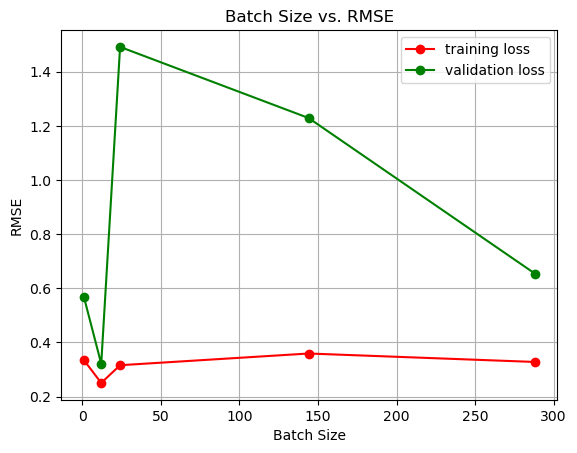

In [99]:
# Plot loss for different batch sizes
plt.plot(figsize=(10,6))
plt.title('Batch Size vs. RMSE')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.grid(True)
plt.plot(batch_num_list, train_rmse, 'r-o', label='training loss') 
plt.plot(batch_num_list, val_rmse, 'g-o', label='validation loss')

plt.legend()
plt.show()

In [101]:
epoch_list   = [5,10,20,50,100]

# Result list
train_rmse =[]
val_rmse = [] 

for epoch in epoch_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(100, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='RMSprop', loss='mse') # This is what we are tuning
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=epoch, batch_size=12, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tEpoch Size: {epoch}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([epoch_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Epochs', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 5
-----------------------
RMSE on training set  : 0.6321
RMSE on validation set: 4.6967
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 10
-----------------------
RMSE on training set  : 0.3208
RMSE on validation set: 0.6733
-----------------------
14/14 [==============================] - 0s 928us/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 20
-----------------------
RMSE on training set  : 0.4634
RMSE on validation set: 4.7017
-----------------------
14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 50
-----------------------
RMSE on training set  : 0.2588
RMSE on validation set: 0.3532
-----------------------
14/14 [==============================] - 0s 2ms/step
-----------------------
  Scoring RNN 

,Epochs,Train RMSE,Val RMSE
0,5,0.632129,4.696686
1,10,0.320822,0.673274
2,20,0.463428,4.701746
3,50,0.258821,0.353169
4,100,0.305844,0.602223


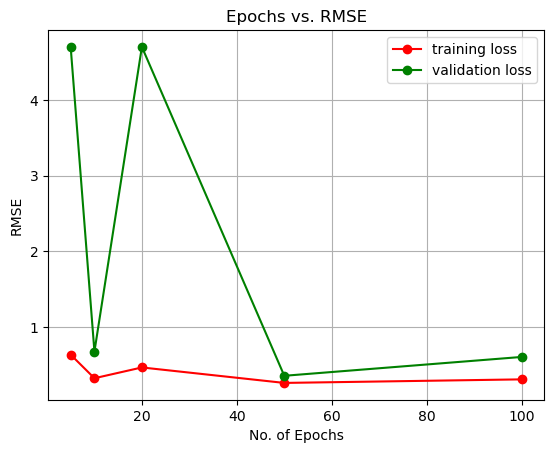

In [102]:
# Plot loss for different epochs
plt.plot(figsize=(10,6))
plt.title('Epochs vs. RMSE')
plt.xlabel('No. of Epochs')
plt.ylabel('RMSE')
plt.grid(True)
plt.plot(epoch_list, train_rmse, 'r-o', label='training loss') 
plt.plot(epoch_list, val_rmse, 'g-o', label='validation loss')

plt.legend()
plt.show()

#### 3.3.3 Convolutional Neural Network ??

In [103]:
## TODO: Discussion inclusion of CNN model (not part of the 3 for reporting)

<a id="4.0"></a>
### 4.0 Model Training & Scoring
- Creating Time Series CV Folds
- Fit and Forecast Models
- Results

[Return to top](#ToC)

#### 4.1 Creating Time Series CV Folds

In [12]:
# Using the Time Series Cross-Validation Splits from our utilities
# This allows us to customize the "stepping size" to take more recent values

train_folds, val_folds = ts_cross_val_split(df_ts, splits=5, forecast_window=24, step=12)

print('Original training data size:', len(df_ts))
print('Size of each cross validation split:')

for n in range(5):
    print(train_folds[n].shape, val_folds[n].shape)

Created 5 splits for cross-validation. Expanding window = 12 months | Forecast window = 24 months
Original training data size: 475
Size of each cross validation split:
(403, 1) (24, 1)
(415, 1) (24, 1)
(427, 1) (24, 1)
(439, 1) (24, 1)
(451, 1) (24, 1)


Plotting the folds to observe the expanding window and what each fold's validation set looks like.

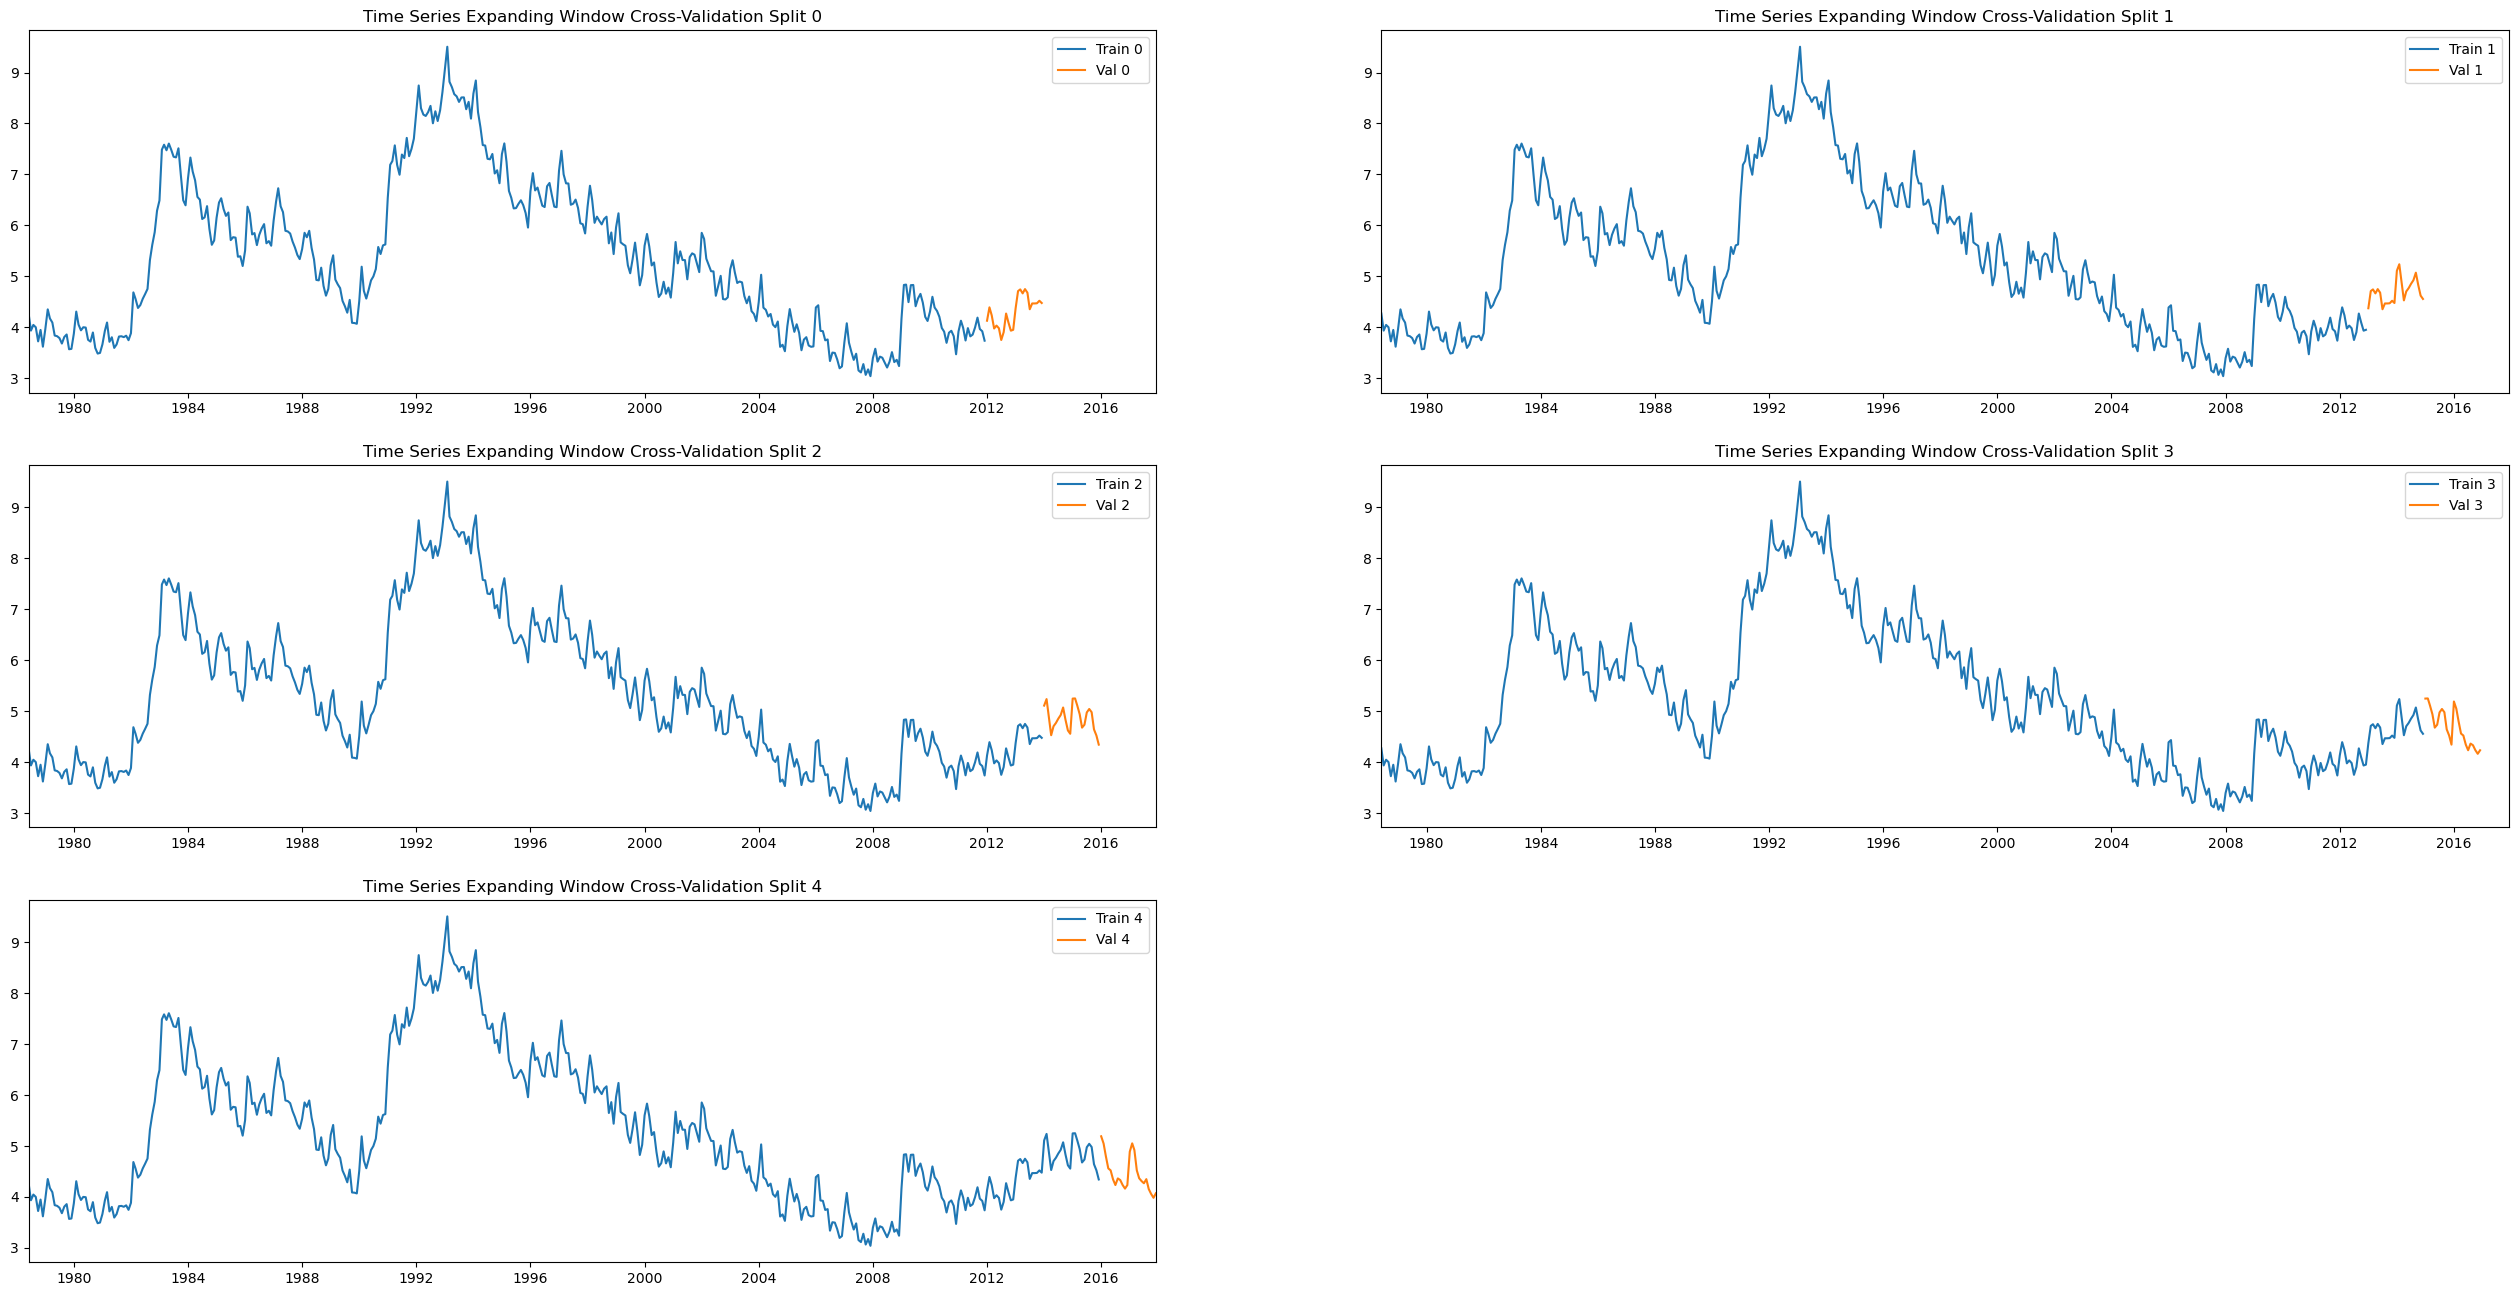

In [13]:
# Plot the train-val splits
plt.figure(figsize=(32,16))
start = min(df_ts.index)
end = xmax=max(df_ts.index)

for i, (df_train, df_val) in enumerate(zip(train_folds, val_folds)):
    ax = plt.subplot(3, 2, i + 1)
    
    ax.set_title(f'Time Series Expanding Window Cross-Validation Split {i}')
    ax.set_xlim(start, end)
    ax.plot(df_train, label=f'Train {i}')
    ax.plot(df_val, label=f'Val {i}')
    ax.legend()

plt.show()

#### 4.2 Define Models

Creating baseline models to set the benchmark for model performance.

In [9]:
# Use the SimpleModel class developed in our utilities module
avg_model = SimpleModel('average')
naive_model = SimpleModel('naive')
drift_model = SimpleModel('drift')
growth_model = SimpleModel('growth')

baseline_models = {'average': avg_model, 'naive': naive_model, 'drift': drift_model, 'growth': growth_model}

In [60]:
# Candidate SARIMAX parameters
ARIMA_orders = [(1,1,1), (1,2,1), (5,3,1)]
ARIMA_seasonal_orders = [(1,0,1,12), (2,1,1,12), (2,1,1,12)]

# Prepare hyper-params for NN models
scaler = MinMaxScaler(feature_range=(0, 1))
time_window = 24

## Autoregressive NN model
FFN_model = Sequential()
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(1))
FFN_model.compile(loss='mean_squared_error', optimizer='adam')
FFN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1600      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [62]:
import time
# Store results for cross-validation loop
cv_predictions = []
cv_results = []

for df_train, df_val in zip(train_folds, val_folds):
    fold_time = time.time()
    model_preds = dict()
    model_results = dict()
    
    # Fit and Forecast Baseline
    for model_key in baseline_models:
        baseline_models[model_key].fit(df_train)
        y_preds = baseline_models[model_key].predict(len(df_val))
        model_preds[model_key] = y_preds
        model_results[model_key] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Holt-Winters
    for HW_seasonal in ['additive', 'multiplicative']:
        hw_model = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal=HW_seasonal).fit()
        y_preds = hw_model.forecast(len(df_val))
        model_preds['HW-'+HW_seasonal] = y_preds
        model_results['HW-'+HW_seasonal] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Seasonal ARIMA
    for order, seasonal_order in zip(ARIMA_orders, ARIMA_seasonal_orders):
        SARIMA_model = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                         order = order,
                                                         seasonal_order = seasonal_order,
                                                         enforce_stationarity = False,
                                                         enforce_invertibility = False,
                                                ).fit()
        y_preds = SARIMA_model.forecast(len(df_val))
        model_preds['SARIMA'+str(order)+str(seasonal_order)] = y_preds
        model_results['SARIMA'+str(order)+str(seasonal_order)] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Neural Nets
    ## Create training data
    train_scaled = scaler.fit_transform(df_train)
    X_scaled, y_scaled = [], []
    for i in range(time_window, len(df_train)):
        #X_train.append(ts_train.iloc[i-time_window:i].values)
        X_scaled.append(train_scaled[i-time_window:i])
        #y_train.append(ts_train.iloc[i].values)
        y_scaled.append(train_scaled[i])

    #X_train = np.array(X_train).reshape(-1,time_window)
    X_scaled = np.array(X_scaled).reshape(-1,time_window)
    #y_train = np.array(y_train).reshape(-1,1)
    y_scaled = np.array(y_scaled).reshape(-1,1)
    
    FFN_model.fit(X_scaled, y_scaled, epochs=50, batch_size=20 , verbose=0)
    
    ## For 24 step ahead, use next prediction as the input for the next time step
    X_val_scaled = train_scaled[-time_window:].reshape(-1,time_window)
    y_preds_scaled = []
    for step in range(time_window):
        next_pred = FFN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        ## Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,1:], next_pred], axis=1)
        
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    model_preds['NN-Autoregressive'] = y_preds
    model_results['NN-Autoregressive'] = RMSE(df_val, y_preds)
    
    # Store results of cross-validation fold
    cv_predictions.append(model_preds)
    cv_results.append(model_results)
    print(f'Completed cross-validation fold in {time.time()-fold_time:.4f} seconds')

print(f'All folds complete. Total Time = {(time.time()-fold_time)/60:.4f} minutes')    

Completed cross-validation fold in 9.9219 seconds
Completed cross-validation fold in 9.7892 seconds
Completed cross-validation fold in 9.7308 seconds
Completed cross-validation fold in 13.4986 seconds
Completed cross-validation fold in 11.7914 seconds
All folds complete. Total Time = 0.1965 minutes


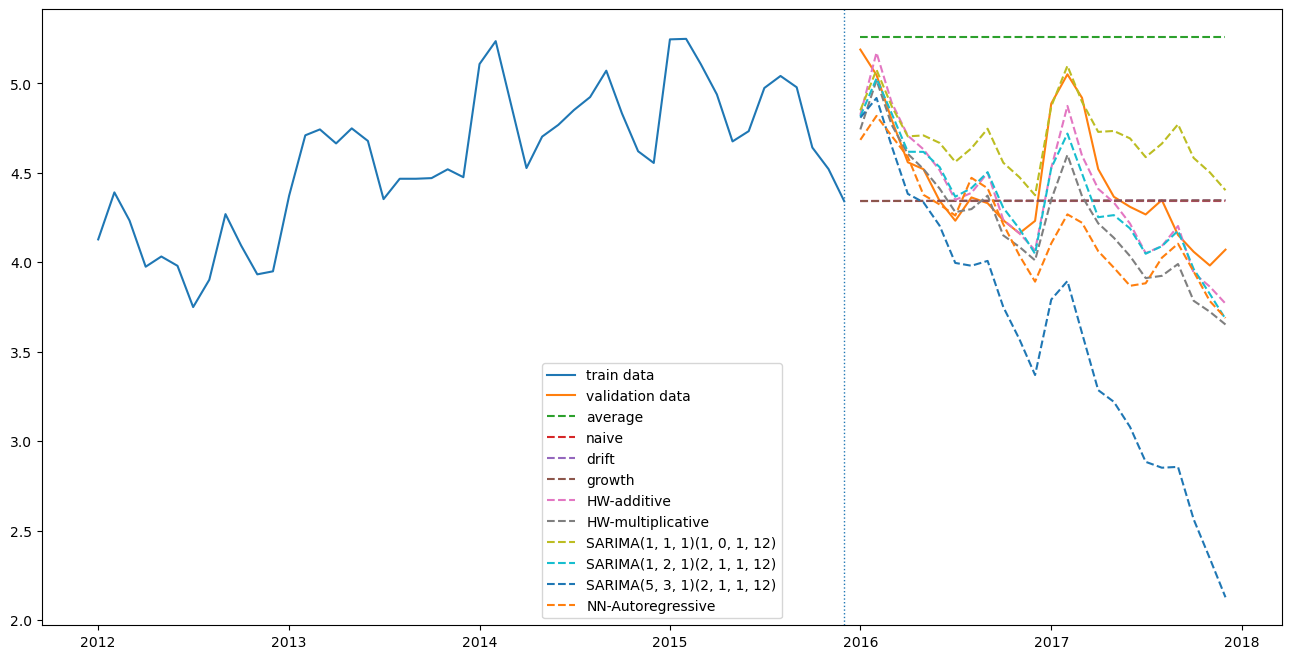

In [67]:
plt.figure(figsize=(16,8))
plt.plot(df_train.index[-48:], df_train.values[-48:], label='train data')
plt.plot(df_val.index, df_val.values, label='validation data')
plt.axvline(x=df_train.index[-1], linestyle='dotted', linewidth=1)
for results in cv_predictions[4]:
    plt.plot(df_val.index, cv_predictions[4][results], linestyle='dashed', label=results)
    
plt.legend(loc='lower center')
plt.show()

In [43]:
naive_model.prediction

4.34229769

In [29]:
pd.DataFrame(cv_results, index=[f'CV-{i}' for i in range(len(train_folds))]).mean(axis=0)

NameError: name 'cv_results' is not defined

<a id="5.0"></a>
### 5.0 Scoring & Evaluation
- Holt-Winters Exponential Smoothing
- Seasonal ARIMA
- Neural Network

[Return to top](#ToC)

### OTHER

## 2. Data Preparation

### 2.1 Create a Training-Validation Split (expanding window)

## 3. Modelling

In [ ]:
df_train = train_folds[1]
df_val = val_folds[1]

df_train.shape, df_val.shape

In [ ]:
avg_model = SimpleModel('average')
naive_model = SimpleModel('naive')
drift_model = SimpleModel('drift')
growth_model = SimpleModel('growth')

simple_models = [avg_model, naive_model, drift_model, growth_model]

# Best fit SARIMA
best_params = [[5, 2, 3], [3, 2, 2, 12]]



In [ ]:
for model in simple_models:
    model.fit(df_train)
    
sarima_model = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                 order = best_params[0],                 # Non-seasonal component
                                                 seasonal_order = best_params[1],     # Seasonal component
                                                 enforce_stationarity = False,
                                                 enforce_invertibility = False,
                                                 freq='MS'
                                                ).fit()
print(f'SARIMAX Fit. Parameters: {best_params}')

In [ ]:
simple_preds = dict()
for i, model in enumerate(simple_models):
    # Simple model predicts 'h' steps ahead
    y_pred = model.predict(df_val.shape[0])
    simple_preds[i] = y_pred
    
# Forecast with SARIMAX
y_pred_sarima = sarima_model.predict(start=df_val.index[0], end=df_val.index[-1])

In [ ]:
# Plot the simple models and their error
plt.figure(figsize=(8,4))

plt.plot(df_train[-50:], c='black')
plt.plot(df_val, c='green', linestyle='dashed')
for i, model in enumerate(simple_models):
    score = RMSE(df_val.values, simple_preds[i])
    plt.plot(df_val.index, simple_preds[i], label=f'Model {i}: {score:.4f} RMSE')
    
score = RMSE(df_val.values, y_pred_sarima.values)
plt.plot(df_val.index, y_pred_sarima, label=f'SARIMAx: {score:.4f} RMSE')

plt.legend()
plt.show()

### Save for Initial Fits

In [ ]:
# Using auto-ARIMA
# Fit your model
model = pm.auto_arima(df_train, seasonal=True, m=12, suppress_warnings=True)

# make your forecasts
forecasts = model.predict(df_val.shape[0])  # predict N steps into the future

In [ ]:
model.get_params()

In [ ]:
df_val.index[-1]

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.plot(df_train.index[-50:], df_train[-50:], c='blue')
plt.plot(df_val.index, df_val, c='orange')
plt.plot(df_val.index, forecasts_2, c='red', linestyle='dashed', linewidth=1)
plt.plot(df_val.index, forecasts, c='green', linestyle='dotted')

plt.show()

In [14]:
df_train.shape

(451, 1)

In [28]:
# Conduct a Grid-Search to find the optimal hyper-params for SARIMA based on our candidates

## NOTE: Grid Search has ~480 parameters, creating a shorter list here for exploration (can run final over time later)

p = [1, 2, 3, 5, 7]
d = [1, 2]
q = [1, 2, 3, 4, 5, 7]
P = [0, 1, 2, 3]
D = [0, 1]
Q = [0, 1, 2]

## REMOVE WHEN USING TRUE PARAMETERS
print('Starting Gridsearch...')
print('Number of params = ', len(p)*len(d)*len(q)*len(P)*len(D)*len(Q))
start_time = time.time()

# Define a SARIMAX model testing all values
store_results = dict()
best_params = [0, 0, 0, 0, 0, 0]
best_rmse = 1_000
for P_trial in P:
    print(f'######### --------- New P Values {P_trial}: Prev took {time.time()-start_time} seconds ---------- #################')
    start_time = time.time()
    for Q_trial in Q:
        for D_trial in D:
            for p_trial in p:
                for q_trial in q:
                    for d_trial in d:
                        order = (p_trial, d_trial, q_trial)
                        seasonal_order = (P_trial, D_trial, Q_trial, 12)
                        model = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                                  order = order,
                                                                  seasonal_order = seasonal_order,
                                                                  enforce_stationarity = False,
                                                                  enforce_invertibility = False,
                                                                 ).fit()


                        forecasts = model.forecast(df_val.shape[0]) # predict N steps into the future
                        error = RMSE(df_val, forecasts)
                        print(f'Fit ({p_trial, d_trial, q_trial})({P_trial, D_trial, Q_trial}): RMSE = {error:.4f}')
                        store_results[str(order)+str(seasonal_order)] = error
                        
                        if error < best_rmse:
                            best_rmse = error
                            best_params = [order,
                                           seasonal_order
                                          ]
                            print('New Best Score!')

print(f'Complete. Best parameters are: {best_params} with error {best_rmse}')

Starting Gridsearch...
Number of params =  1440
######### --------- New P Values 0: Prev took 0.0 seconds ---------- #################
Fit ((1, 1, 1))((0, 0, 0)): RMSE = 0.3655
New Best Score!
Fit ((1, 2, 1))((0, 0, 0)): RMSE = 0.3610
New Best Score!
Fit ((1, 1, 2))((0, 0, 0)): RMSE = 0.3479
New Best Score!
Fit ((1, 2, 2))((0, 0, 0)): RMSE = 0.3654
Fit ((1, 1, 3))((0, 0, 0)): RMSE = 0.3487
Fit ((1, 2, 3))((0, 0, 0)): RMSE = 0.3508
Fit ((1, 1, 4))((0, 0, 0)): RMSE = 0.3509


KeyboardInterrupt: 

In [27]:
print(len(store_results))
print(min(store_results, key=store_results.get))

1440
(1, 2, 7)(0, 1, 2, 12)


In [19]:
vals = np.array([store_results[x] for x in store_results])
vals.shape

(1440,)

In [23]:
pd.DataFrame(data=vals, index=store_results, columns=['RMSE']).to_csv('SARIMA_Grid_Search.csv')

In [26]:
sorted(store_results.items(), key=lambda item: item[1])

[('(1, 2, 7)(0, 1, 2, 12)', 0.15145157369734305),
 ('(7, 2, 3)(3, 1, 0, 12)', 0.15216693942694023),
 ('(7, 2, 1)(0, 1, 1, 12)', 0.1526923996518615),
 ('(7, 2, 1)(3, 1, 0, 12)', 0.15284877021327625),
 ('(7, 2, 1)(1, 1, 2, 12)', 0.15301113383811618),
 ('(3, 2, 7)(0, 1, 2, 12)', 0.1532914815959078),
 ('(7, 2, 1)(1, 1, 1, 12)', 0.15388857311011622),
 ('(7, 2, 3)(0, 1, 2, 12)', 0.15400755603589605),
 ('(7, 2, 3)(0, 1, 1, 12)', 0.15406336182986566),
 ('(5, 2, 2)(1, 1, 2, 12)', 0.15407655410265192),
 ('(7, 2, 2)(0, 1, 1, 12)', 0.15420471904619795),
 ('(5, 2, 2)(0, 1, 1, 12)', 0.1542124997186708),
 ('(1, 2, 7)(0, 1, 1, 12)', 0.1543762787698104),
 ('(7, 2, 1)(0, 1, 2, 12)', 0.1545011329778141),
 ('(5, 2, 2)(0, 1, 2, 12)', 0.154542338839533),
 ('(7, 2, 2)(1, 1, 1, 12)', 0.1546494666690799),
 ('(7, 2, 3)(1, 1, 1, 12)', 0.154790166525772),
 ('(5, 2, 1)(1, 1, 2, 12)', 0.15520711023942269),
 ('(2, 2, 7)(1, 1, 2, 12)', 0.1552199051918123),
 ('(7, 2, 1)(2, 1, 1, 12)', 0.15558784727017205),
 ('(7, 2, 3

In [ ]:
best_params = [[5, 2, 3], [3, 2, 2, 12]]
print(best_params, error)

In [ ]:
model_tuned = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                order = best_params[0],                 # Non-seasonal component
                                                seasonal_order = best_params[1],     # Seasonal component
                                                enforce_stationarity = False,
                                                enforce_invertibility = False,
                                                freq='MS'
                                               ).fit()


forecasts_tuned = model_tuned.predict(df_val.index[0], df_val.index[-1])

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.plot(df_train.index[-50:], df_train[-50:], c='blue')
plt.plot(df_val.index, df_val, c='orange')
plt.plot(df_val.index, forecasts, c='green', linestyle='dotted')
plt.plot(df_val.index, forecasts_2, c='red', linestyle='dashed', linewidth=1)
plt.plot(df_val.index, forecasts_tuned, c='purple', linestyle='dashed')

plt.show()